In [6]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from pathlib import Path
from PIL import Image
import torchvision.utils as vutils
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.notebook import tqdm
import math
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from annoy import AnnoyIndex

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
image_size = 224
std,mean = [0.229, 0.224, 0.225],[0.485, 0.456, 0.406] # pretrained models used these values

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [9]:
def imshow(img, title='', std=std, mean=mean,figsize=(16,16)):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.figure (figsize = figsize)
    plt.imshow(img)
    plt.title(title)

In [10]:
# Custom dataset with file name https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [11]:
data_dir = Path.cwd() / 'index_images'
dataset = ImageFolderWithPaths(data_dir,transform=test_transform) # our custom dataset

In [12]:
bs=128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=False,num_workers=8)

In [14]:
class EmbeddingExtractor:
    def sniff_output(self,model, input, output):
        self.embeddings=output  
    def __init__(self):
        self.model = models.resnet34(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 251)
        self.model = self.model.to(device)
        self.model.load_state_dict(torch.load('model.pt'))
        self.model.eval()
        layer = self.model._modules.get('avgpool')
        self.handle = layer.register_forward_hook(self.sniff_output)
    def get_embeddings(self, input):
        with torch.no_grad():
            self.model(input.to(device))
        return self.embeddings.squeeze(-1).squeeze(-1)
extractor = EmbeddingExtractor()

In [15]:
t = AnnoyIndex(512, 'euclidean')

In [16]:
for batch in tqdm(dataloader):
    embeddings = extractor.get_embeddings(batch[0])
    for i in range(len(batch[2])):
        emb = embeddings[i]
        img_id = os.path.basename(batch[2][i]).split('.')[0]
        t.add_item(int(img_id),emb)

In [17]:
t.build(5) # 5 trees
t.save('tree_5.ann')

True

In [123]:
print(t.get_nns_by_vector(dataset[100][0],9))

IndexError: Vector has wrong length (expected 512, got 3)

In [98]:
dataset[1]

(tensor([[[ 1.7009,  1.7352,  1.8037,  ...,  0.7248,  1.2214,  1.5468],
          [ 1.8037,  1.8037,  1.8037,  ...,  0.6734,  0.6221,  1.8893],
          [ 1.6667,  1.6667,  1.6495,  ...,  0.0741, -0.0287,  1.0673],
          ...,
          [-1.3473, -1.4158, -1.2959,  ..., -1.1589, -1.2445, -1.0219],
          [-0.8849, -1.2788, -1.2959,  ..., -0.9534, -0.4397, -0.2171],
          [-2.1179,  0.0569, -1.1418,  ..., -0.1828,  0.0741,  0.2624]],
 
         [[ 2.1134,  2.1134,  2.1134,  ...,  1.3957,  1.8859,  2.2535],
          [ 2.2010,  2.1835,  2.1485,  ...,  1.3957,  1.3256,  2.4286],
          [ 2.1134,  2.0784,  2.0259,  ...,  0.8704,  0.7304,  1.8333],
          ...,
          [-1.1429, -1.2304, -1.1078,  ..., -2.0357, -2.0357, -1.8782],
          [-0.6702, -1.0903, -1.1078,  ..., -1.8431, -1.3179, -1.0203],
          [-1.9307,  0.2752, -0.9503,  ..., -0.8452, -0.5826, -0.3025]],
 
         [[ 2.5529,  2.5354,  2.5180,  ..., -0.5147,  0.0431,  0.0779],
          [ 2.6400,  2.6051,

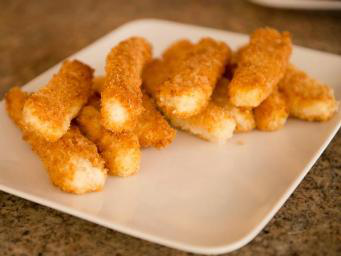

In [133]:
im = Image.open("/home/yonatang/deepfood/notebooks/index_images/dummy/107212.jpg")
display(im)

In [28]:
def tensor_to_pil(image):
    image = (image.permute(1,2,0)) * torch.tensor(std) + torch.tensor(mean)
    image = image.permute(2,0,1)
    return image

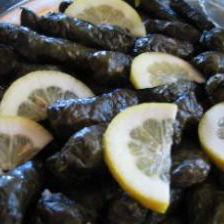

In [31]:
im = transforms.ToPILImage()(tensor_to_pil(train_dataset[70]['image']))
display(im)

In [32]:
im.save('tmp_pics/yoni.jpg')

In [33]:
train_dataset[70]

{'image': tensor([[[-1.3130, -1.2959, -1.2959,  ...,  0.0912,  0.1768,  0.1768],
          [-1.2959, -1.3130, -1.3473,  ...,  0.0056,  0.1939,  0.1597],
          [-1.2788, -1.3130, -1.3815,  ..., -0.0629,  0.2111,  0.2282],
          ...,
          [-1.6727, -1.6384, -1.6213,  ..., -1.3302, -1.3302, -1.3302],
          [-1.6727, -1.6213, -1.5870,  ..., -1.1760, -1.2103, -1.1932],
          [-1.6727, -1.6042, -1.5528,  ..., -1.0562, -1.0390, -1.0219]],
 
         [[-0.8803, -0.8277, -0.8102,  ...,  0.7129,  0.8004,  0.7829],
          [-0.8627, -0.8452, -0.8627,  ...,  0.6078,  0.8004,  0.7654],
          [-0.8627, -0.8803, -0.9153,  ...,  0.5378,  0.8179,  0.8354],
          ...,
          [-1.6506, -1.6155, -1.5980,  ..., -1.3179, -1.3179, -1.2829],
          [-1.6506, -1.5980, -1.5630,  ..., -1.1604, -1.1954, -1.1429],
          [-1.6506, -1.5805, -1.5280,  ..., -1.0378, -1.0203, -0.9678]],
 
         [[-0.4101, -0.3055, -0.1835,  ...,  1.3154,  1.4025,  1.3677],
          [-0.3927,

In [ ]:
for i,batch in enumerate(tqdm(train_dataloader)):
    emb = extractor.get_embeddings(batch['image'].to(device)).detach().cpu()
    all_emb=torch.cat([all_emb,emb],dim=0)